# Train a lane keeping autopilot with Keras + Tensorflow. 

This document walks through how to create a convolution neural network using Keras+Tensorflow and train it to keep a car between two white lines.

Here is a Raspberry Pi controlled RC car using the autopilot crated in this document to drive between the lines. See [the donkey repository](https://github.com/wroscoe/donkey) for instructions to build your own car.

!['self driving rc car'](http://i.giphy.com/B6R47UtKkW4Fi.gif)


In [29]:
import os
import urllib.request
import pickle

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

### Get the driving data
The dataset is combosed of ~7000 images collected as I manually drove the car. About 2/3 of the images are with the car between the lines. The other third is of the car starting off course and correcting by driving back to between the lines.  

In [18]:
#downlaod driving data (450Mb) 
data_url = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
file_path, headers = urllib.request.urlretrieve(data_url)
print(file_path)

/tmp/tmpxfza_k_2


X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)


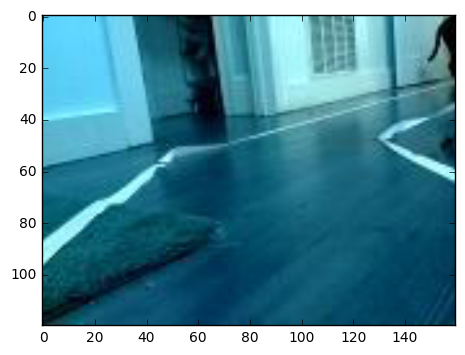

In [19]:
#extract data
with open(file_path, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[0])

### Augment Data
To double our training data and prevent steering bias, we can flip each image and steering angle. There are other ways to augment data using shifts and fake shadows but I didn't use those for this autopilot. 

In [20]:
import numpy as np

In [21]:
X_flipped = np.array([np.fliplr(i) for i in X])
Y_flipped = np.array([-i for i in Y])
X = np.concatenate([X, X_flipped])
Y = np.concatenate([Y, Y_flipped])

### Build a driving model

This driving model will be an end-to-end neural network that accepts image arrays as input and outputs a steering angle between -90 (left) and 90 (right). To do this we'll use a 3 layer convolution network with one fully connected layer. This model is based off of [Otavio's Carputer](https://github.com/otaviogood/carputer/blob/master/NeuralNet/convnetshared1.py) but does not produce a throttle value output, does not use past steering values as input into the model, and uses one less convolution layer.

In [32]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense


In [23]:
img_in = Input(shape=(120, 160, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

### Train the model. 
I've learned the hard way that even if everything else to this point is correct, your autopilot won't work if you don't train it correctly. The biggest problem I ran into was over fitting the model so that it would not work in evenlly slightly different scenarios. Here are 2 Keras callbacks that will save you time. 

**Warning - This will take a long time if only using a CPU**

I ran this notebook on my Dell XPS notebook that does not have a CUDA compatible GPU so it's very slow and freezes. To speed up training you can uses a EC2 instance with a GPU. Several instance images exist with Keras and Tensorflow already loaded. 

In [24]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [ ]:
model.fit(X, Y, nb_epoch=100, validation_split=.2, callbacks=callbacks_list)

Train on 12627 samples, validate on 3157 samples
Epoch 1/100
12627/12627 [==============================] - 344s - loss: 644.6835 - val_loss: 970.3928
Epoch 2/100
12627/12627 [==============================] - 389s - loss: 370.1224 - val_loss: 930.0800
Epoch 3/100
12627/12627 [==============================] - 384s - loss: 299.5584 - val_loss: 855.4384
Epoch 4/100
12627/12627 [==============================] - 379s - loss: 273.7977 - val_loss: 957.9663
Epoch 5/100
12627/12627 [==============================] - 395s - loss: 244.7123 - val_loss: 979.3878
Epoch 6/100
12627/12627 [==============================] - 388s - loss: 223.3658 - val_loss: 870.0322
Epoch 7/100
12627/12627 [==============================] - 378s - loss: 206.8365 - val_loss: 858.4761
Epoch 8/100
12627/12627 [==============================] - 416s - loss: 166.7056 - val_loss: 755.6551
Epoch 12/100
12627/12627 [==============================] - 396s - loss: 146.5027 - val_loss: 865.0495
Epoch 15/100
 7008/12627 [======

### Evaluate Performance
We  can spot check our model to see if's producing reasonable values by plotting the predicted vs actual. Even though our model didn't complete it's training, we can see that the steering angles are being prediced reasonably accurately.

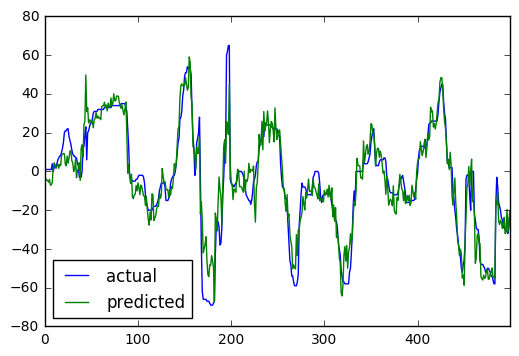

In [37]:
import pandas as pd

model = load_model(model_path)

P = model.predict(X[:500])
#predict outputs nested arrays so we need to reshape to plot.
P = P.reshape((P.shape[0],)) 

pd.DataFrame({'predicted':P, 'actual':Y[:500]}).plot()

## Next steps
* **Improve Model** This model is naieve because it doesn't use past values to help predict the future. We could experiment with the model by feeding past steering angles as inputs to the model, add a recurrent layer, or just change the structure of the convolution layers. 
* **Add more data** This model will improve as we add more driving data. 
* **Predict throttle outputs** Currently the autopilot only steers and maintains a constant speed. A more sophisticated model would speed up on straightaways and slow down before curbs.
